<a href="https://colab.research.google.com/github/jaeparkim/ShallowMind/blob/main/BoundaryDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baselines and model perplexity

Model perplexity is essentially a way of measuring the similarity of a probability distribution with a sample from that distribution.

## Assumptions

- We must have the underlying model which the sentence that we compute perplexity for was generated from.
- For a sentence not from the assumed distribution, but treated as if it was, the perplexity should be large.
- The perplexity is minimized for a sample drawn from the argmax of the distribution. For sentences, this means the most probably sentence has the lowest perplexity.

## Perplexity equation

$\text{PPL}(s) = e^{-\frac{1}{N}\sum_{i=1}^N \log p_{\theta}(x_i|x_{<i})}$

The $\log p_{\theta}(x_i|x_{<i})$ term is just the log-likelihood of our model which is also just the Cross-Entropy of the input of the model with respect to the predicted output.

## Perplexity features

- We decided to use 10 features for each sample where feature $i$ is the perplexity on sentences 0 through $i$ in the prompt.
- Each prompt has the generated part from either GPT2, GPT2-XL, or a finetuned model. The perplexity is calculated with the same model used to generate the prompt.
- Standardized

## Predictions (no ML!)
- Find where the perplexity significantly decreases, and predict that as the boundary between human and machine.
- Each perplexity feature must be normalized or else this will not work well. Perplexity is already normalized by sentence length, but we still perform an extra normalization step.
- Performance is highly dependent on the word sampling method.
  - For top-p with p=0.4 this gets worse than majority accuracy.


## Load data

Loading precomputed perplexity features. We also load the full dataset and filter out a bad annotator as well as aggregate all the human predicted boundaries by taking the average.

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import torch
import torchvision
!pip install transformers
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # use GPU if available
print(f"Using device: {device}")
drive.mount('/content/drive')
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 8.5 MB/s eta 0:00:00
Using device: cuda:0
Mounted at /content/drive


In [ ]:


X_gpt2_red_04 = np.load('/content/drive/Shareddrives/CSCI566 Final Project/perplexity/X_perp_gpt2_red_04.npy')
y_gpt2_red_04 = np.load('/content/drive/Shareddrives/CSCI566 Final Project/perplexity/y_perp_gpt2_red_04.npy')

X_gpt2xl_red_00 = np.load('/content/drive/Shareddrives/CSCI566 Final Project/perplexity/X_perp_gpt2xl_red_00.npy')
y_gpt2xl_red_00 = np.load('/content/drive/Shareddrives/CSCI566 Final Project/perplexity/y_perp_gpt2xl_red_00.npy')
X_gpt2xl_red_04 = np.load('/content/drive/Shareddrives/CSCI566 Final Project/perplexity/X_perp_gpt2xl_red_04.npy')
y_gpt2xl_red_04 = np.load('/content/drive/Shareddrives/CSCI566 Final Project/perplexity/y_perp_gpt2xl_red_04.npy')
X_gpt2xl_red_10 = np.load('/content/drive/Shareddrives/CSCI566 Final Project/perplexity/X_perp_gpt2xl_red_10.npy')
y_gpt2xl_red_10 = np.load('/content/drive/Shareddrives/CSCI566 Final Project/perplexity/y_perp_gpt2xl_red_10.npy')

X_gpt2xl_nyt_00 = np.load('/content/drive/Shareddrives/CSCI566 Final Project/perplexity/X_perp_gpt2xl_nyt_00.npy')
y_gpt2xl_nyt_00 = np.load('/content/drive/Shareddrives/CSCI566 Final Project/perplexity/y_perp_gpt2xl_nyt_00.npy')
X_gpt2xl_nyt_04 = np.load('/content/drive/Shareddrives/CSCI566 Final Project/perplexity/X_perp_gpt2xl_nyt_04.npy')
y_gpt2xl_nyt_04 = np.load('/content/drive/Shareddrives/CSCI566 Final Project/perplexity/y_perp_gpt2xl_nyt_04.npy')
X_gpt2xl_nyt_10 = np.load('/content/drive/Shareddrives/CSCI566 Final Project/perplexity/X_perp_gpt2xl_nyt_10.npy')
y_gpt2xl_nyt_10 = np.load('/content/drive/Shareddrives/CSCI566 Final Project/perplexity/y_perp_gpt2xl_nyt_10.npy')

X_gpt2xl_rec_04 = np.load('/content/drive/Shareddrives/CSCI566 Final Project/perplexity/X_perp_gpt2xl_rec_04.npy')
y_gpt2xl_rec_04 = np.load('/content/drive/Shareddrives/CSCI566 Final Project/perplexity/y_perp_gpt2xl_rec_04.npy')

X_finetuned_rec_04 = np.load('/content/drive/Shareddrives/CSCI566 Final Project/perplexity/X_perp_finetuned_rec_04.npy')
y_finetuned_rec_04 = np.load('/content/drive/Shareddrives/CSCI566 Final Project/perplexity/y_perp_finetuned_rec_04.npy')

FileNotFoundError: ignored

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/Shareddrives/CSCI566 Final Project/data.csv')

# Delete the bad actor from our data
df = df[df['annotator'] != 4334]
df = df.drop_duplicates(subset='generation')

# Average all predicted boundary indexes for the same text
df_orig = df.copy()
avg_pbis = []
for i,row in df.iterrows():
  pbis = df_orig[df_orig['generation'] == row['generation']]['predicted_boundary_index']
  avg_pbi = np.average(pbis)
  avg_pbis.append(int(np.round(avg_pbi)))
df['avg_pbi'] = avg_pbis

## Data exploration

The following show the distribution of average predicted boundary and the true predicted boundary. We see that there is an imbalance in both the percentage of true boundary of 9 as well as average predicted boundary of 9.

The third plot is a rough depiction of how well humans are at correctly predicting the true boundary.

Text(0.5, 0, 'Average predicted boundary')

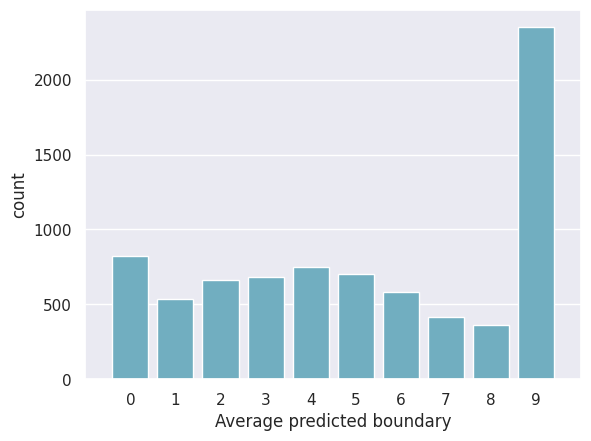

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

bxp = sns.countplot(data=df, x='avg_pbi', color='c')
bxp.set_xlim(-1, 10)
bxp.set_xlabel("Average predicted boundary")

Text(0.5, 0, 'True boundary')

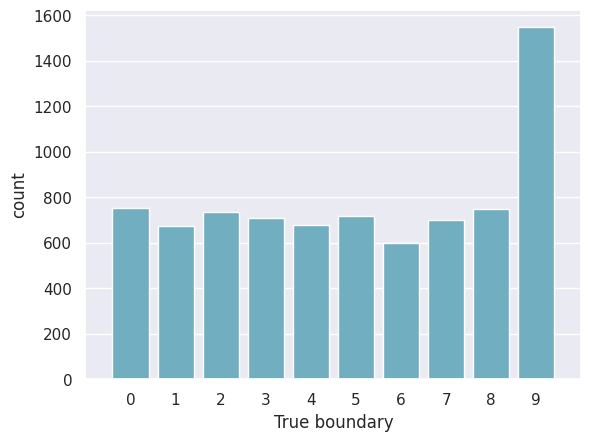

In [ ]:
bxp = sns.countplot(data=df, x='true_boundary_index', color='c')
bxp.set_xlim(-1, 10)
bxp.set_xlabel("True boundary")

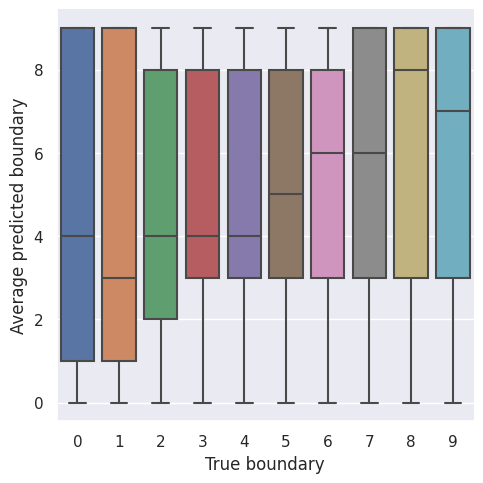

In [ ]:
plt = sns.catplot(kind="box", data=df, x='true_boundary_index', y='avg_pbi')
# plt = sns.violinplot(data=df, x='true_boundary_index', y='avg_pbi')
plt.set(xlabel="True boundary")
plt.set(ylabel="Average predicted boundary")

## Baselines

In the following, we will perform the baseline evaluations and the perplexity baseline for the true boundary data. This will show the general workflow for generating the data and results, and the method for evaluating on the average predicted boundary is exactly the same, except we replace 'true_boundary_index' with 'avg_pbi'.

First, we will preprocess the data to get each subset as a list of the ten sentences and the corresponding true boundary and the average human prediction.

In [ ]:
# Creates a list of tuples (Text, Index) 
# Text = String of sentences (separated by _SEP_) 
# Index = index of the last human written sentence in Text

def create_index_list(df, model, dataset, top_p):
  temp_df = pd.DataFrame()
  df_model_dataset = df[(df['model'] == model) & (df['dataset'] == dataset) & (df['dec_strat_value'] == top_p)]

  temp_df['text'] = df_model_dataset['prompt_body'] + '_SEP_' + df_model_dataset['gen_body'].fillna('')
  temp_df['boundary'] = df_model_dataset['true_boundary_index']
  temp_df['human'] = df_model_dataset['avg_pbi']
  return list(temp_df.to_records(index=False))

# Creating separate index lists for each subset of the data and the full dataset
il_gpt2_red_04 = create_index_list(df, "gpt2", "Short Stories", 0.4)
il_gpt2xl_red_00 = create_index_list(df, "gpt2-xl", "Short Stories", 0.0)
il_gpt2xl_red_04 = create_index_list(df, "gpt2-xl", "Short Stories", 0.4)
il_gpt2xl_red_10 = create_index_list(df, "gpt2-xl", "Short Stories", 1.0)
il_gpt2xl_nyt_00 = create_index_list(df, "gpt2-xl", "New York Times", 0.0)
il_gpt2xl_nyt_04 = create_index_list(df, "gpt2-xl", "New York Times", 0.4)
il_gpt2xl_nyt_10 = create_index_list(df, "gpt2-xl", "New York Times", 1.0)
il_gpt2xl_rec_04 = create_index_list(df, "gpt2-xl", "Recipes", 0.4)
il_finetuned_rec_04 = create_index_list(df, "finetuned", "Recipes", 0.4)

temp_df = pd.DataFrame()
temp_df['text'] = df['prompt_body'] + '_SEP_' + df['gen_body'].fillna('')
temp_df['boundary'] = df['true_boundary_index']
temp_df['human'] = df['avg_pbi']
il_all = list(temp_df.to_records(index=False))
print(len(il_all))

7861


In [ ]:
# The data will have many duplicates because it represents user attempts at
# guessing the boundary. We want to remove all duplicates since we only care
# about the actual ground truth.
from collections import OrderedDict

def clean_index_list(index_list):
  dedup_index_list = index_list
  print("Total unique samples:", len(dedup_index_list))

  cleaned_prompts = []
  cleaned_boundary = []
  cleaned_hum = []
  for row in dedup_index_list:
    tmp = []
    for sentence in row[0].split("_SEP_"):
      tmp.append(sentence)
    if len(tmp) >= 10:
      cleaned_prompts.append(tmp[0:10])
      cleaned_boundary.append(row[1])
      cleaned_hum.append(row[2])
  return cleaned_prompts, cleaned_boundary, cleaned_hum

In [ ]:
# Creating the cleaned list of 10 sentences per sample as well as the true 
# boundary and average human predicted boundary.
prompt_gpt2_red_04, bound_gpt2_red_04, hum_gpt2_red_04 = clean_index_list(il_gpt2_red_04)
prompt_gpt2xl_red_00, bound_gpt2xl_red_00, hum_gpt2xl_red_00 = clean_index_list(il_gpt2xl_red_00)
prompt_gpt2xl_red_04, bound_gpt2xl_red_04, hum_gpt2xl_red_04 = clean_index_list(il_gpt2xl_red_04)
prompt_gpt2xl_red_10, bound_gpt2xl_red_10, hum_gpt2xl_red_10 = clean_index_list(il_gpt2xl_red_10)
prompt_gpt2xl_nyt_00, bound_gpt2xl_nyt_00, hum_gpt2xl_nyt_00 = clean_index_list(il_gpt2xl_nyt_00)
prompt_gpt2xl_nyt_04, bound_gpt2xl_nyt_04, hum_gpt2xl_nyt_04 = clean_index_list(il_gpt2xl_nyt_04)
prompt_gpt2xl_nyt_10, bound_gpt2xl_nyt_10, hum_gpt2xl_nyt_10 = clean_index_list(il_gpt2xl_nyt_10)
prompt_gpt2xl_rec_04, bound_gpt2xl_rec_04, hum_gpt2xl_rec_04 = clean_index_list(il_gpt2xl_rec_04)
prompt_finetuned_rec_04, bound_finetuned_rec_04, hum_finetuned_rec_04 = clean_index_list(il_finetuned_rec_04)
all, all_labels, all_hum = clean_index_list(il_all)
print(len(all_labels))

Total unique samples: 1217
Total unique samples: 195
Total unique samples: 217
Total unique samples: 196
Total unique samples: 501
Total unique samples: 460
Total unique samples: 488
Total unique samples: 1657
Total unique samples: 2539
Total unique samples: 7861
7788


Now, we perform our three baseline evaluations: the random baseline, the majority baseline, and the perplexity-based baseline.

### Random and majority baseline

In [ ]:
from random import randrange, seed
from scipy import stats

# Random baseline function
seed(42069)
def rand_baseline():
  return randrange(10)


# Majority baseline function
def maj_baseline(labels):
  return stats.mode(labels)[0][0]

In [ ]:
for (X, y, y_hum) in [(prompt_gpt2xl_nyt_00, bound_gpt2xl_nyt_00, hum_gpt2xl_nyt_00),
                      (prompt_gpt2xl_nyt_04, bound_gpt2xl_nyt_04, hum_gpt2xl_nyt_04),
                      (prompt_gpt2xl_nyt_10, bound_gpt2xl_nyt_10, hum_gpt2xl_nyt_10),
                      (prompt_gpt2_red_04, bound_gpt2_red_04, hum_gpt2_red_04),
                      (prompt_gpt2xl_red_00, bound_gpt2xl_red_00, hum_gpt2xl_red_00),
                      (prompt_gpt2xl_red_04, bound_gpt2xl_red_04, hum_gpt2xl_red_04),
                      (prompt_gpt2xl_red_10, bound_gpt2xl_red_10, hum_gpt2xl_red_10),
                      (prompt_gpt2xl_rec_04, bound_gpt2xl_rec_04, hum_gpt2xl_rec_04),
                      (prompt_finetuned_rec_04, bound_finetuned_rec_04, hum_finetuned_rec_04),
                      (all, all_labels, all_hum)]:
  N = len(y)
  y = np.array(y)
  pred_rand = np.array([rand_baseline() for i in range(len(y))])
  mode = maj_baseline(y)

  pred_maj = np.array([mode for i in range(len(y))])
  rand_acc = (y == pred_rand).sum() / N
  maj_acc = (y == pred_maj).sum() / N
  hum_acc = (y == np.array(y_hum)).sum() / N
  print("Random accuracy:", rand_acc)
  print("Maj accuracy:", maj_acc)
  print("Human accuracy:", hum_acc)
  print("\n")

Random accuracy: 0.1377245508982036
Maj accuracy: 0.12375249500998003
Human accuracy: 0.1536926147704591


Random accuracy: 0.08695652173913043
Maj accuracy: 0.11739130434782609
Human accuracy: 0.1391304347826087


Random accuracy: 0.10245901639344263
Maj accuracy: 0.1168032786885246
Human accuracy: 0.1885245901639344


Random accuracy: 0.09942481511914544
Maj accuracy: 0.20542317173377156
Human accuracy: 0.2563681183237469


Random accuracy: 0.11282051282051282
Maj accuracy: 0.1282051282051282
Human accuracy: 0.10256410256410256


Random accuracy: 0.11981566820276497
Maj accuracy: 0.1152073732718894
Human accuracy: 0.14285714285714285


Random accuracy: 0.10714285714285714
Maj accuracy: 0.14285714285714285
Human accuracy: 0.23469387755102042


Random accuracy: 0.10067114093959731
Maj accuracy: 0.50091519219036
Human accuracy: 0.35143380109823064


Random accuracy: 0.09452540370224498
Maj accuracy: 0.11697518708152817
Human accuracy: 0.246947617172115


Random accuracy: 0.1023369286081

<ipython-input-9-a08c1c10dd56>:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return stats.mode(labels)[0][0]


### Perplexity baseline

Before constructing the detection model, we standardize the data because our model will use the largest change in perplexity value to make the detection, so we want each feature to be measured on the same scale.

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

all_X = np.concatenate([X_gpt2_red_04, X_gpt2xl_nyt_00, X_gpt2xl_nyt_04, X_gpt2xl_nyt_10, X_gpt2xl_rec_04, X_gpt2xl_red_00, X_gpt2xl_red_04, X_gpt2xl_red_10, X_finetuned_rec_04], axis=0)
all_y = np.concatenate([y_gpt2_red_04, y_gpt2xl_nyt_00, y_gpt2xl_nyt_04, y_gpt2xl_nyt_10, y_gpt2xl_rec_04, y_gpt2xl_red_00, y_gpt2xl_red_04, y_gpt2xl_red_10, y_finetuned_rec_04], axis=0)

scaler = StandardScaler()
for X in [X_gpt2_red_04,
          X_gpt2xl_red_00,
          X_gpt2xl_red_04,
          X_gpt2xl_red_10,
          X_gpt2xl_nyt_00,
          X_gpt2xl_nyt_04,
          X_gpt2xl_nyt_10,
          X_gpt2xl_rec_04,
          X_finetuned_rec_04,
          all_X]:
  X[:,:] = scaler.fit_transform(X)

The perplexity-based detection baseline works by calculating a moving average of window size 2 over the perplexity features from left to right and predicting the location of greatest decrease in perplexity. This model was devised by noting that the perplexity reflects how well a sentence matches the model's distribution over sentences, so a generated sentence should have lower perplexity than a human sentence.

When we test this on all our subsets of data, we see that this hunch was correct since for prompts generated with a p=0.0, our baseline performs very well compared to random and majority class while as p increases the performance decreases.

In [ ]:
# Find boundary between human and machine generated text based on greatest
# decrease in moving average.
def sliding_dec(features):
  '''Perplexity-based detection model'''
  window = features[0] + features[1]
  last = 0
  greatest_dec = 0.0
  best_loc = 0
  for i in range(2, 10):
    next_window = window + features[i] - features[last]
    if (window - next_window) >= greatest_dec:
      greatest_dec = (window - next_window)
      best_loc = i - 2
    window = next_window
    last += 1
  return best_loc

In [ ]:
def get_perp_baseline_acc(data, labels):
  pred = []
  for i in range(data.shape[0]):
    pred.append(sliding_dec(data[i]))

  pred = np.array(pred)
  acc = (labels == pred).sum() / labels.shape[0]
  return acc


print("GPT2-XL NYT p=0.0 accuracy:\t", get_perp_baseline_acc(X_gpt2xl_nyt_00, y_gpt2xl_nyt_00))
print("GPT2-XL NYT p=0.4 accuracy:\t", get_perp_baseline_acc(X_gpt2xl_nyt_04, y_gpt2xl_nyt_04))
print("GPT2-XL NYT p=1.0 accuracy:\t", get_perp_baseline_acc(X_gpt2xl_nyt_10, y_gpt2xl_nyt_10))
print("GPT2 Reddit p=0.4 accuracy:\t", get_perp_baseline_acc(X_gpt2_red_04, y_gpt2_red_04))
print("GPT2-XL Reddit p=0.0 accuracy:\t", get_perp_baseline_acc(X_gpt2xl_red_00, y_gpt2xl_red_00))
print("GPT2-XL Reddit p=0.4 accuracy:\t", get_perp_baseline_acc(X_gpt2xl_red_04, y_gpt2xl_red_04))
print("GPT2-XL Reddit p=1.0 accuracy:\t", get_perp_baseline_acc(X_gpt2xl_red_10, y_gpt2xl_red_10))
print("GPT2-XL Recipes p=0.4 accuracy:\t", get_perp_baseline_acc(X_gpt2xl_rec_04, y_gpt2xl_rec_04))
print("Finetuned Rec. p=0.4 accuracy:\t", get_perp_baseline_acc(X_finetuned_rec_04, y_finetuned_rec_04))
print("Aggregate accuracy:\t", get_perp_baseline_acc(all_X, all_y))

# Swaraj Vatsa RoBERTa Word Embedding Calculation

Importing raw data from RoFT project


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/566/data.csv')

Mounted at /content/drive


Cleaning and de-duplicating the dataset: we leave only one instance of each prompt/generation pair, and remove paragaphs which are less than 10 sentences

In [ ]:
df = df.drop_duplicates(subset='generation')
df = df.fillna('')
df['full_text'] = df['prompt_body'] + "_SEP_" + df['gen_body']
df = df[df.apply(lambda x: len(x['full_text'].split("_SEP_")) >= 10,axis=1)]

Train/val/test split (80%,10%,10%) for our whole dataset: we will embed all of the text in each class separately.

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_val_test = train_test_split(df,test_size=0.2, random_state=42069)
df_val, df_test = train_test_split(df_val_test, test_size=0.5,random_state=42069)

data_train = np.array(df_train['full_text'])
data_val = np.array(df_val['full_text'])
data_test = np.array(df_test['full_text'])



In [ ]:
!pip install transformers

Initialize the pre-trained model, and send it to the GPU

In [ ]:
from transformers import RobertaTokenizer, RobertaModel
import torch
model = RobertaModel.from_pretrained('roberta-base',
                                  output_hidden_states = True,
                                  )

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
device = torch.device('cuda:0')
model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

Code to embed a single sentence. We embed each of its tokens by running the model and taking the last hidden layer. These embeddings are then averaged to get the overall embedding for a sentence

In [ ]:
def embed(text):

  
  # Tokenize and prepare text
  marked_text = "[CLS] " + text + " [SEP]"
  tokenized_text = tokenizer.tokenize(marked_text)[:512]
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1]*len(indexed_tokens)

  tokens_tensor = torch.tensor([indexed_tokens]).to(device)
  segments_tensors = torch.tensor([segments_ids]).to(device)
  
  # Evaluate the Roberta model on the token sequence
  with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2][1:]

  # Embeddings are final layer
  token_embeddings = hidden_states[-1]
  token_embeddings = torch.squeeze(token_embeddings, dim=0)
  list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

  list_token_embeddings = np.reshape(list_token_embeddings,(len(tokenized_text),768))

  #Average embeddings over the sentence
  return np.average(list_token_embeddings,axis=0)    

To embed a single piece of text, we concatenate the embeddings of its first ten sentences.

In [ ]:
def embed_datum(datum):
  return np.concatenate(np.vectorize(embed,otypes=[np.ndarray])(datum.split("_SEP_")[0:10]))

In [ ]:
from tqdm import tqdm
data_train_embedded = []
for text in tqdm(data_train):
  vec = np.array(embed_datum(text))
  data_train_embedded.append(vec)
data_train_embedded = np.stack(np.array(data_train_embedded))

data_test_embedded = []
for text in tqdm(data_test):
  vec = np.array(embed_datum(text))
  data_test_embedded.append(vec)
data_test_embedded = np.array(data_test_embedded)

data_val_embedded = []
for text in tqdm(data_val):
  vec = np.array(embed_datum(text))
  data_val_embedded.append(vec)
data_val_embedded = np.array(data_val_embedded)

100%|██████████| 946/946 [02:19<00:00,  6.76it/s]


In [ ]:
# np.save('/content/drive/Shareddrives/CSCI566 Final Project/data_train_embedded.npy', data_train_embedded)
# np.save('/content/drive/Shareddrives/CSCI566 Final Project/data_test_embedded.npy', data_test_embedded)
# np.save('/content/drive/Shareddrives/CSCI566 Final Project/data_val_embedded.npy', data_val_embedded)

# SRoBERTa Word Embedding & Coherency Score Calculation

Installs the necessary dependencies and creates an instance of the pre-trained Sentence Transformers model

In [ ]:
import nltk
nltk.download('punkt')
from sentence_transformers import SentenceTransformer
from scipy import spatial
from nltk.tokenize import sent_tokenize

model = SentenceTransformer('sentence-transformers/nli-roberta-large').to(device='cuda')

The functions below create the sentence-level word embeddings and calculate the semantic textual similary between pairs of adjacent sentences:
- compute_similarity: tokenizes the sentences and computes the average cosine similarity between pairs of adjacent sentences
- process_index_list_element: preprocesses the example
- create_input_data: creates the X-train dataset in the appropriate format

In [ ]:
def compute_similarity(sentences):
  embeddings = model.encode(sentences)
  scores = []
  for i in range(len(embeddings)-1):
    sen1 = embeddings[i]
    sen2 = embeddings[i+1]
    similarity_score = 1 - spatial.distance.cosine(sen1, sen2)
    scores.append(similarity_score)
  return scores, embeddings.tolist()

def process_index_list_element(x):
  sentences = []
  for i, s in enumerate(x.split("_SEP_")):
    s = s.replace('\n', " ")
    sentences.append(s)
  return sentences[:10]

def create_input_data(data):
  count = 0
  X = []
  E = []
  for d in data:
    sentences = process_index_list_element(d)
    scores, embeddings = compute_similarity(sentences)
    X.append(scores)
    E.append(embeddings)
    count += 1
    if(count%100 == 0):
      print(count)
  return X, E


Load the embeddings + scores (previously run)

In [ ]:
X_train_scores = np.load('/content/drive/Shareddrives/CSCI566 Final Project/coherence/X_train_sentence_scores.npy').tolist()
X_test_scores = np.load('/content/drive/Shareddrives/CSCI566 Final Project/coherence/X_test_sentence_scores.npy').tolist()
X_train_embeddings = np.load('/content/drive/Shareddrives/CSCI566 Final Project/coherence/X_train_sentence_embeddings.npy')
X_test_embeddings = np.load('/content/drive/Shareddrives/CSCI566 Final Project/coherence/X_test_sentence_embeddings.npy')

The code below loads the data from drive and preprocesses it as follows: 
- filtering out datapoints where the sentences are greater than 10
- removing any duplicate examples
- ensuring that no duplicates exists between the training and testing subsets

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/CSCI566 Final Project/data.csv')
df = df.fillna('')

df_orig = df.copy()
avg_pbis = []
for i,row in df.iterrows():
  pbis = df_orig[df_orig['generation'] == row['generation']]['predicted_boundary_index']
  avg_pbi = np.average(pbis)
  avg_pbis.append(np.round(avg_pbi))
df['avg_pbi'] = avg_pbis

df_filtered = df[df.apply(lambda x: len((x['prompt_body'] + x['gen_body']).split("_SEP_")) >= 10, axis=1)]

df_train, df_test_val = train_test_split(df_filtered, test_size=0.20, random_state=42069)
df_test, df_val = train_test_split(df_test_val, test_size=0.5, random_state=42069)

df_train = df_train.drop_duplicates(subset=['generation'],keep='first')
df_test = df_test.drop_duplicates(subset=['generation'],keep='first')
test_generations = list(df_test['generation'])
df_train = df_train[df_train.apply(lambda x: not (x['generation'] in test_generations),axis=1)]



In [ ]:
df_train

,date,annotator,model,dec_strat_value,dataset,prompt,prompt_body,generation,gen_body,predicted_boundary_index,true_boundary_index,points,reason,major,recipe_familiarity,news_familiarity,stories_familiarity,gen_familiarity,read_guide,avg_pbi
20131,2021-10-14 01:11:54.110000+00:00,5158,gpt2-xl,0.4,Recipes,21300,HOW TO MAKE: Fiesta Baked Chicken\nIngredients...,27590,,8,9,0,"['irrelevant', 'repetition']",['CIS'],4,2,2,-1,Yes,8.0
23073,2021-10-15 01:26:45.704000+00:00,5357,ctrl,0.4,Presidential Speeches,13342,"""Press Conference in the East Room"" by Preside...",18295,,9,9,5,[],['MCIT'],3,2,2,2,Yes,7.0
5834,2021-09-08 16:03:59.930000+00:00,2649,finetuned,0.4,Recipes,17021,HOW TO MAKE: Chicken Francese with Lemon and P...,22144,Place 2 tablespoons of Pecorino on each piece ...,6,0,0,['common_sense'],['ROBO'],4,4,3,1,,5.0
27434,2021-10-16 03:06:49.360000+00:00,4968,finetuned,0.4,Recipes,19077,HOW TO MAKE: Cheddar-Polenta Biscuits with Ham...,24651,Transfer the biscuits to the prepared baking s...,3,4,0,['common_sense'],['MCIT'],2,2,1,1,Yes,6.0
5713,2021-09-08 12:53:06.900000+00:00,2608,finetuned,0.4,Recipes,14783,HOW TO MAKE: White Chocolate Mousse with Pomeg...,27275,,8,9,0,['irrelevant'],['DATS'],4,2,4,1,,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6496,2021-09-08 22:04:58.842000+00:00,1800,gpt2-xl,0.4,Short Stories,2926,That lost sort of longing lingers as snow fall...,8962,The right sleeve covers my name._SEP_The left ...,0,1,0,['grammar'],"['CIS', 'MATH']",2,5,2,4,,0.0
27427,2021-10-16 03:05:36.379000+00:00,4896,finetuned,0.4,Recipes,20075,HOW TO MAKE: Chicken Broccoli Casserole\nIngre...,25795,Just watch the cooking time so it doesn't get ...,6,6,5,['irrelevant'],['MCIT'],4,3,1,-1,Yes,6.0
4492,2021-09-06 22:48:05.955000+00:00,2171,finetuned,0.4,Recipes,20447,"HOW TO MAKE: Pasta with Braised Fennel, Chard,...",26171,"Use 2 cups broccoli florets, 2 cups kale, 1/3 ...",7,7,5,[],['CIS'],3,3,3,2,,7.0
5073,2021-09-08 00:15:59.441000+00:00,2554,gpt2,0.4,Short Stories,3003,My baby girl looked at me and laughed as she b...,21459,I told her I would like it if you could take m...,1,1,5,['irrelevant'],['PHYS'],3,1,2,1,,1.0


In [ ]:
np.save('/content/drive/Shareddrives/CSCI566 Final Project/coherence/X_train_sentence_scores.npy', X_train_scores)
np.save('/content/drive/Shareddrives/CSCI566 Final Project/coherence/X_test_sentence_scores.npy', X_test_scores)
np.save('/content/drive/Shareddrives/CSCI566 Final Project/coherence/X_train_sentence_embeddings.npy', X_train_embeddings)
np.save('/content/drive/Shareddrives/CSCI566 Final Project/coherence/X_train_sentence_embeddings.npy', data_val_embedded)

In [ ]:
df_train['coherency'] = X_train_scores
df_test['coherency'] = X_test_scores

X_train_embeddings_flat = []
for x in X_train_embeddings:
  X_train_embeddings_flat.append(x.ravel().tolist())

X_test_embeddings_flat = []
for x in X_test_embeddings:
  X_test_embeddings_flat.append(x.ravel().tolist())

df_train['embeddings'] = X_train_embeddings_flat
df_test['embeddings'] = X_test_embeddings_flat

# SRoBERTa Classifier Experimentation

We ran experiments on a variety of classifiers in order to determine which model was best able to use the SRoBERTa scores to predict the true boundary index. 

*In order to replicate our results for predicted boundary, replace df_train['true_boundary_index'] and df_test['true_boundary_index'] with df_train['avg_pbi'] and df_test['avg_pbi'] respectively*

For each classifier, GridSearchCV was run in order to determine the optimal hyperparameters. The parameters shown in the instatiation of each classifier below are the highest performing for each respective model.

The models below show SRoBERTa experimentation. NOTE: this section will take a considerably long time to run  

In [ ]:
from sklearn import preprocessing
from sklearn import metrics

X_train = np.stack(df_train['embeddings'])
X_test = np.stack(df_test['embeddings'])
y_train = np.stack(df_train['true_boundary_index'])
y_test = np.stack(df_test['true_boundary_index'])

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_acc = []
test_acc = []

Logistic Regression

In [ ]:
from sklearn import linear_model
lr = linear_model.LogisticRegression(
    penalty='l2',
    random_state=42069,
    multi_class='multinomial',
    solver = 'lbfgs',
    max_iter = 100,
    C = 0.0005)

lr.fit(X_train_scaled, y_train)

print("Train accuracy " + str(metrics.accuracy_score(lr.predict(X_train_scaled),y_train)))
print("Test accuracy " + str(metrics.accuracy_score(lr.predict(X_test_scaled),y_test)))
print("Train MAE " + str(metrics.mean_absolute_error(lr.predict(X_train_scaled),y_train)))
print("Test MAE " + str(metrics.mean_absolute_error(lr.predict(X_test_scaled),y_test)))

train_acc.append(metrics.accuracy_score(lr.predict(X_train_scaled), y_train))
test_acc.append(metrics.accuracy_score(lr.predict(X_test_scaled), y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train accuracy 0.8521209740769835
Test accuracy 0.41084513922813876
Train MAE 0.5701099764336214
Test MAE 2.1231069858329263


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators = 500,
    criterion = 'entropy',
    max_depth = 2, 
    random_state=42069, 
    max_features = 'auto')
rf.fit(X_train_scaled, y_train)

print("Train accuracy " + str(metrics.accuracy_score(rf.predict(X_train_scaled),y_train)))
print("Test accuracy " + str(metrics.accuracy_score(rf.predict(X_test_scaled),y_test)))
print("Train MAE " + str(metrics.mean_absolute_error(rf.predict(X_train_scaled),y_train)))
print("Test MAE " + str(metrics.mean_absolute_error(rf.predict(X_test_scaled),y_test)))

train_acc.append(metrics.accuracy_score(rf.predict(X_train_scaled), y_train))
test_acc.append(metrics.accuracy_score(rf.predict(X_test_scaled), y_test))

Train accuracy 0.2152395915161037
Test accuracy 0.2154372252076209
Train MAE 3.9988216810683426
Test MAE 3.94333170493405


K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors = 37,
    algorithm = 'auto',
    weights = 'uniform')

knn.fit(X_train_scaled,y_train)

print("Train accuracy " + str(metrics.accuracy_score(knn.predict(X_train_scaled),y_train)))
print("Test accuracy " + str(metrics.accuracy_score(knn.predict(X_test_scaled),y_test)))
print("Train MAE " + str(metrics.mean_absolute_error(knn.predict(X_train_scaled),y_train)))
print("Test MAE " + str(metrics.mean_absolute_error(knn.predict(X_test_scaled),y_test)))

train_acc.append(metrics.accuracy_score(knn.predict(X_train_scaled), y_train))
test_acc.append(metrics.accuracy_score(knn.predict(X_test_scaled), y_test))

Train accuracy 0.3375883739198743
Test accuracy 0.2706399609184172
Train MAE 2.6842105263157894
Test MAE 2.78114313629702


Neural Network

In [ ]:
from sklearn import neural_network

mlp = neural_network.MLPClassifier(
    learning_rate='adaptive',
    activation='identity',
    hidden_layer_sizes = (512, 512))

mlp.fit(X_train,y_train)

print("Train accuracy " + str(metrics.accuracy_score(mlp.predict(X_train_scaled),y_train)))
print("Test accuracy " + str(metrics.accuracy_score(mlp.predict(X_test_scaled),y_test)))
print("Train MAE " + str(metrics.mean_absolute_error(mlp.predict(X_train_scaled),y_train)))
print("Test MAE " + str(metrics.mean_absolute_error(mlp.predict(X_test_scaled),y_test)))

train_acc.append(metrics.accuracy_score(mlp.predict(X_train_scaled), y_train))
test_acc.append(metrics.accuracy_score(mlp.predict(X_test_scaled), y_test))

Train accuracy 0.9465828750981933
Test accuracy 0.3248656570591109
Train MAE 0.2786724273369992
Test MAE 2.376648754274548


Multiclass SVM

In [ ]:
from sklearn.svm import SVC

svm = SVC(gamma='scale',
          kernel = 'poly',
          max_iter = 100,
          C = 0.005)

svm.fit(X_train_scaled, y_train)

from sklearn import metrics
print("Train accuracy " + str(metrics.accuracy_score(svm.predict(X_train_scaled),y_train)))
print("Test accuracy " + str(metrics.accuracy_score(svm.predict(X_test_scaled),y_test)))
print("Train MAE " + str(metrics.mean_absolute_error(svm.predict(X_train_scaled),y_train)))
print("Test MAE " + str(metrics.mean_absolute_error(svm.predict(X_test_scaled),y_test)))

train_acc.append(metrics.accuracy_score(svm.predict(X_train_scaled), y_train))
test_acc.append(metrics.accuracy_score(svm.predict(X_test_scaled), y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Train accuracy 0.2586410054988217
Test accuracy 0.22911577918905715
Train MAE 3.749214454045562
Test MAE 3.794333170493405


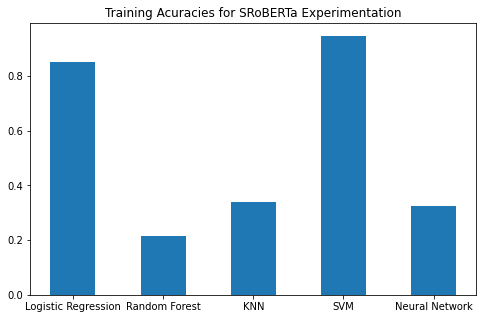

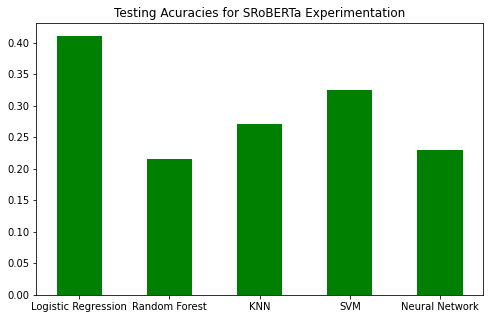

In [ ]:
import matplotlib.pyplot as plt

labels = ['Logistic Regression', 'Random Forest', 'KNN', 'SVM', 'Neural Network']
fig = plt.figure(figsize=(8, 5))
plt.title("Training Acuracies for SRoBERTa Experimentation")
plt.bar(labels, train_acc[:5], width = 0.5)
plt.show()

fig = plt.figure(figsize=(8, 5))
plt.title("Testing Acuracies for SRoBERTa Experimentation")
plt.bar(labels, test_acc[:5], width = 0.5, color = 'g')
plt.show()


# Semantic Textual Similarity (Coherency) Classifier Experimentation

We ran experiments on a variety of classifiers in order to determine which model was best able to use sentence-level coherence scores to predict the true boundary index. 

*In order to replicate our results for predicted boundary, replace df_train['true_boundary_index'] and df_test['true_boundary_index'] with df_train['avg_pbi'] and df_test['avg_pbi'] respectively*

For each classifier, GridSearchCV was run in order to determine the optimal hyperparameters. The parameters shown in the instatiation of each classifier below are the highest performing for each respective model.

The models below show STS experimentation 

In [ ]:
from sklearn import preprocessing
from sklearn import metrics

X_train = np.stack(df_train['coherency'])
X_test = np.stack(df_test['coherency'])
y_train = np.stack(df_train['true_boundary_index'])
y_test = np.stack(df_test['true_boundary_index'])

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_acc = []
test_acc = []

Logistic Regression

In [ ]:
from sklearn import linear_model
lr = linear_model.LogisticRegression(
    penalty='l2',
    random_state=42069,
    multi_class='multinomial',
    solver = 'lbfgs',
    max_iter = 100,
    C = 0.5)

lr.fit(X_train_scaled, y_train)

print("Train accuracy " + str(metrics.accuracy_score(lr.predict(X_train_scaled),y_train)))
print("Test accuracy " + str(metrics.accuracy_score(lr.predict(X_test_scaled),y_test)))
print("Train MAE " + str(metrics.mean_absolute_error(lr.predict(X_train_scaled),y_train)))
print("Test MAE " + str(metrics.mean_absolute_error(lr.predict(X_test_scaled),y_test)))

train_acc.append(metrics.accuracy_score(lr.predict(X_train_scaled), y_train))
test_acc.append(metrics.accuracy_score(lr.predict(X_test_scaled), y_test))

Train accuracy 0.22388059701492538
Test accuracy 0.21836834391792867
Train MAE 3.7390023566378634
Test MAE 3.764533463605276


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators = 500,
    criterion = 'entropy',
    max_depth = 2, 
    random_state=42069, 
    max_features = 'auto')
rf.fit(X_train_scaled, y_train)

print("Train accuracy " + str(metrics.accuracy_score(rf.predict(X_train_scaled),y_train)))
print("Test accuracy " + str(metrics.accuracy_score(rf.predict(X_test_scaled),y_test)))
print("Train MAE " + str(metrics.mean_absolute_error(rf.predict(X_train_scaled),y_train)))
print("Test MAE " + str(metrics.mean_absolute_error(rf.predict(X_test_scaled),y_test)))

train_acc.append(metrics.accuracy_score(rf.predict(X_train_scaled), y_train))
test_acc.append(metrics.accuracy_score(rf.predict(X_test_scaled), y_test))

Train accuracy 0.2152395915161037
Test accuracy 0.2154372252076209
Train MAE 3.9988216810683426
Test MAE 3.94333170493405


K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors = 37,
    algorithm = 'auto',
    weights = 'uniform')

knn.fit(X_train_scaled,y_train)

print("Train accuracy " + str(metrics.accuracy_score(knn.predict(X_train_scaled),y_train)))
print("Test accuracy " + str(metrics.accuracy_score(knn.predict(X_test_scaled),y_test)))
print("Train MAE " + str(metrics.mean_absolute_error(knn.predict(X_train_scaled),y_train)))
print("Test MAE " + str(metrics.mean_absolute_error(knn.predict(X_test_scaled),y_test)))

train_acc.append(metrics.accuracy_score(knn.predict(X_train_scaled), y_train))
test_acc.append(metrics.accuracy_score(knn.predict(X_test_scaled), y_test))

Train accuracy 0.2541241162608013
Test accuracy 0.20517830972154372
Train MAE 3.3289473684210527
Test MAE 3.4982901807523206


Neural Network

In [ ]:
from sklearn import neural_network

mlp = neural_network.MLPClassifier(
    learning_rate='adaptive',
    activation='identity',
    hidden_layer_sizes = (512, 512))

mlp.fit(X_train,y_train)

print("Train accuracy " + str(metrics.accuracy_score(mlp.predict(X_train_scaled),y_train)))
print("Test accuracy " + str(metrics.accuracy_score(mlp.predict(X_test_scaled),y_test)))
print("Train MAE " + str(metrics.mean_absolute_error(mlp.predict(X_train_scaled),y_train)))
print("Test MAE " + str(metrics.mean_absolute_error(mlp.predict(X_test_scaled),y_test)))

train_acc.append(metrics.accuracy_score(mlp.predict(X_train_scaled), y_train))
test_acc.append(metrics.accuracy_score(mlp.predict(X_test_scaled), y_test))

Train accuracy 0.16064414768263943
Test accuracy 0.14118221787982413
Train MAE 3.624901806755695
Test MAE 3.7401074743527114


Multiclass SVM

In [ ]:
from sklearn.svm import SVC

svm = SVC(gamma='scale',
          kernel = 'poly',
          max_iter = 100,
          C = 0.0004)

svm.fit(X_train_scaled, y_train)

from sklearn import metrics
print("Train accuracy " + str(metrics.accuracy_score(svm.predict(X_train_scaled),y_train)))
print("Test accuracy " + str(metrics.accuracy_score(svm.predict(X_test_scaled),y_test)))
print("Train MAE " + str(metrics.mean_absolute_error(svm.predict(X_train_scaled),y_train)))
print("Test MAE " + str(metrics.mean_absolute_error(svm.predict(X_test_scaled),y_test)))

train_acc.append(metrics.accuracy_score(svm.predict(X_train_scaled), y_train))
test_acc.append(metrics.accuracy_score(svm.predict(X_test_scaled), y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Train accuracy 0.21445404556166536
Test accuracy 0.21201758671226184
Train MAE 3.9738805970149254
Test MAE 3.9340498290180754


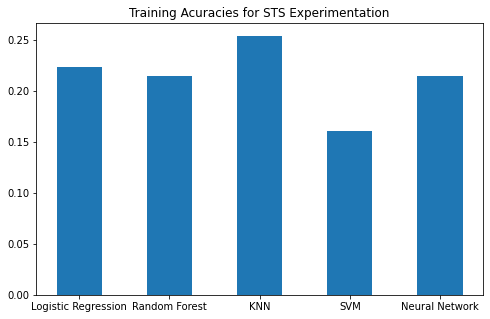

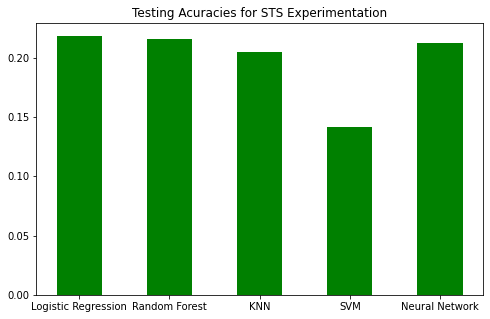

In [ ]:
import matplotlib.pyplot as plt

labels = ['Logistic Regression', 'Random Forest', 'KNN', 'SVM', 'Neural Network']
fig = plt.figure(figsize=(8, 5))
plt.title("Training Acuracies for STS Experimentation")
plt.bar(labels, train_acc, width = 0.5)
plt.show()

fig = plt.figure(figsize=(8, 5))
plt.title("Testing Acuracies for STS Experimentation")
plt.bar(labels, test_acc, width = 0.5, color = 'g')
plt.show()


# Model Analysis: Subset Testing

The final model selected was Logistic Regression, calculated by averaging the highest test accuracy outputted by a model trained on all three embedding types (RoBERTa, SRoBERTa, Coherency)

In order to analyze which subsets of data our model performed the best/worst on, we filtered by how the machine-generated text was created (gpt2, gpt2-xl, finetuned) and what the source of the human-written text was included (New York Times, Reddit Short Stories, Recipes)

The code below shows text generated by gpt2-xl using recipes as a prompt

In [ ]:
df_train_model = df_train[df_train['model'] == 'gpt2-xl']
df_test_model = df_test[df_test['model'] == 'gpt2-xl']
print(len(df_train_model))

df_train_p = df_train_model[df_train_model['dec_strat_value'] == 0.4]
df_test_p = df_test_model[df_test_model['dec_strat_value'] == 0.4]
print(len(df_train_p))

df_train_domain = df_train_p[df_train_p['dataset'] == 'Recipes']
df_test_domain = df_test_p[df_test_p['dataset'] == 'Recipes']
print(len(df_train_domain))

2459
1574
1111


We also experimented with in-domain vs. out-of-domain training and how that impacted prediction accuracy

In [ ]:
embeddings = True
in_domain = True

if(embeddings):
  if(in_domain):
    X_train = np.stack(df_train_domain['embeddings'])
    X_test = np.stack(df_test_domain['embeddings'])
  else:
    X_train = np.stack(df_train['embeddings'])
    X_test = np.stack(df_test_domain['embeddings'])
else:
  if(in_domain):
    X_train = np.stack(df_train_domain['coherency'])
    X_test = np.stack(df_test_domain['coherency'])
  else:
    X_train = np.stack(df_train['coherency'])
    X_test = np.stack(df_test_domain['coherency'])

if(in_domain):
  y_train = np.stack(df_train_domain['true_boundary_index'])
  y_test = np.stack(df_test_domain['true_boundary_index'])
else:
  y_train = np.stack(df_train['true_boundary_index'])
  y_test = np.stack(df_test_domain['true_boundary_index'])

# Swaraj Vatsa RoBERTa Classifier Experimentation

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/566/data.csv')
df = df.fillna('')
df_orig = df.copy()
df = df.drop_duplicates(subset='generation')
df['full_text'] = df['prompt_body'] + "_SEP_" + df['gen_body']
df = df[df.apply(lambda x: len(x['full_text'].split("_SEP_")) >= 10,axis=1)]

Train/test split, initial data prep.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

df_train, df_val_test = train_test_split(df,test_size=0.2, random_state=42069)
df_val, df_test = train_test_split(df_val_test, test_size=0.5,random_state=42069)

# data_train_embedded = np.load('/content/drive/Shareddrives/CSCI566 Final Project/data_train_embedded.npy') 
# data_val_embedded = np.load('/content/drive/Shareddrives/CSCI566 Final Project/data_val_embedded.npy') 
# data_test_embedded = np.load('/content/drive/Shareddrives/CSCI566 Final Project/data_test_embedded.npy') 

df_train['embedded'] = data_train_embedded.tolist()
df_val['embedded'] = data_val_embedded.tolist()
df_test['embedded'] = data_test_embedded.tolist()

del data_train_embedded
del data_test_embedded
del data_val_embedded

df_train = df_train.drop_duplicates(subset='prompt')
df_test = df_test.drop_duplicates(subset='prompt')
df_val = df_val.drop_duplicates(subset='prompt')

`subset` takes a subset of a dataframe with the given parameters, `get_train_test` gets the subsets of the traininng and test data with those parameters.

In [ ]:
#domain: "New York Times", "Short Stories", "Recipes"
#model: "gpt2", "gpt2-xl", "finetuned"
#top_p: 0.0, 0.4, 1.0

def subset(df, domain, model, top_p):
  df_filtered = df[df['dec_strat_value'] == top_p]
  df_filtered = df_filtered[df_filtered["model"] == model]
  df_filtered = df_filtered[df_filtered["dataset"] == domain]
  return df_filtered

def get_train_test(domain,model,top_p,tset):
  df_test_filtered = subset(df_test,domain,model,top_p)
  if tset == "ID":
    df_train_filtered = subset(df_train,domain,model,top_p)
  elif tset == "OOD":
    df_train_filtered = df_train.copy()
  else:
    raise Exception("Need tset = ID or OOD")

  X_train = np.stack(np.array(df_train_filtered['embedded']))
  y_train = np.array(df_train_filtered['true_boundary_index'])
  X_test = np.stack(np.array(df_test_filtered['embedded']))
  y_test = np.array(df_test_filtered['true_boundary_index'])

  return X_train, y_train, X_test,y_test


Train and fit a logistic regression!

In [ ]:
domain = "New York Times"
model = "gpt2-xl"
top_p = 1.0
tset = "OOD"

X_train, y_train, X_test,y_test = get_train_test(domain,model,top_p,tset)

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import metrics

scaler = StandardScaler()  
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)

lr = linear_model.LogisticRegression(
  penalty='l2',
  random_state=42069,
  multi_class='multinomial',
  max_iter = 200
)

lr.fit(X_train_scaled,y_train)
acc = metrics.accuracy_score(lr.predict(X_test_scaled),y_test)
print("Test accuracy: " + str(acc))

Test accuracy: 0.5517241379310345


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KNN

In [ ]:
from sklearn import neighbors
from sklearn import metrics

domain = "New York Times"
model = "gpt2-xl"
top_p = 0.4
tset = "OOD"

X_train, y_train, X_test,y_test = get_train_test(domain,model,top_p,tset)

Ks = [1,3,5,10,20,50]


for K in Ks:
  lr = neighbors.KNeighborsClassifier(
    n_neighbors=K,
  )
  lr.fit(X_train,y_train)

  print("K=" + str(K))
  print("Train acc: " + str(metrics.accuracy_score(lr.predict(X_train),y_train)))
  print("Test acc: " + str(metrics.accuracy_score(lr.predict(X_test),y_test)))

K=1
Train acc: 1.0
Test acc: 0.2777777777777778
K=3
Train acc: 0.5232118758434547
Test acc: 0.1388888888888889
K=5
Train acc: 0.46396761133603237
Test acc: 0.08333333333333333
K=10
Train acc: 0.3707152496626181
Test acc: 0.1111111111111111
K=20
Train acc: 0.33589743589743587
Test acc: 0.08333333333333333
K=50
Train acc: 0.2844804318488529
Test acc: 0.08333333333333333


Multi-layer perceptron

In [ ]:
from sklearn import neural_network
from sklearn.preprocessing import StandardScaler  
from sklearn import metrics

scaler = StandardScaler()  
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)


mlp = neural_network.MLPClassifier(
    learning_rate='adaptive'
)
mlp.fit(X_train,y_train)

print("Train accuracy " + str(metrics.accuracy_score(mlp.predict(X_train),y_train)))
print("Test accuracy " + str(metrics.accuracy_score(mlp.predict(X_test),y_test)))

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train accuracy 1.0
Test accuracy 0.4166666666666667


# Swaraj Vatsa SRoBERTa Classifier

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/566/data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = df.drop_duplicates(subset='generation')
df = df.fillna('')
df['full_text'] = df['prompt_body'] + "_SEP_" + df['gen_body']
df = df[df.apply(lambda x: len(x['full_text'].split("_SEP_")) >= 10,axis=1)]

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_val_test = train_test_split(df,test_size=0.2, random_state=42069)
df_val, df_test = train_test_split(df_val_test, test_size=0.5,random_state=42069)

data_train = np.array(df_train['full_text'])
data_val = np.array(df_val['full_text'])
data_test = np.array(df_test['full_text'])

In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-distilroberta-base-v2')

device = torch.device('cuda:0')
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [ ]:
def embed(long_sentence):

  max_seq_length = model.get_max_seq_length()

  segments = []
  for i in range(0, len(long_sentence), max_seq_length):
      segment = long_sentence[i:i+max_seq_length]
      segments.append(segment)

  if(len(segments) == 0):
    segments = ["the end"]
  segment_embeddings = []

  for segment in segments:
      if(len(segment)>0):
        segment_embedding = model.encode(segment)
        segment_embeddings.append(segment_embedding)

  long_sentence_embedding = np.mean(segment_embeddings, axis=0)
  return long_sentence_embedding  

In [ ]:
def embed_datum(datum):
  return np.concatenate(np.vectorize(embed,otypes=[np.ndarray])(datum.split("_SEP_")[0:10]))

In [ ]:
from tqdm import tqdm
data_train_embedded = []
for text in tqdm(data_train):
  vec = np.array(embed_datum(text))
  data_train_embedded.append(vec)
data_train_embedded = np.stack(np.array(data_train_embedded))

data_test_embedded = []
for text in tqdm(data_test):
  vec = np.array(embed_datum(text))
  data_test_embedded.append(vec)
data_test_embedded = np.array(data_test_embedded)

data_val_embedded = []
for text in tqdm(data_val):
  vec = np.array(embed_datum(text))
  data_val_embedded.append(vec)
data_val_embedded = np.array(data_val_embedded)

100%|██████████| 946/946 [01:27<00:00, 10.87it/s]


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/566/data.csv')
df = df.fillna('')
df_orig = df.copy()
df = df.drop_duplicates(subset='generation')
df['full_text'] = df['prompt_body'] + "_SEP_" + df['gen_body']
df = df[df.apply(lambda x: len(x['full_text'].split("_SEP_")) >= 10,axis=1)]

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

df_train, df_val_test = train_test_split(df,test_size=0.2, random_state=42069)
df_val, df_test = train_test_split(df_val_test, test_size=0.5,random_state=42069)

# data_train_embedded = np.load('/content/drive/Shareddrives/CSCI566 Final Project/data_train_embedded.npy') 
# data_val_embedded = np.load('/content/drive/Shareddrives/CSCI566 Final Project/data_val_embedded.npy') 
# data_test_embedded = np.load('/content/drive/Shareddrives/CSCI566 Final Project/data_test_embedded.npy') 

df_train['embedded'] = data_train_embedded.tolist()
df_val['embedded'] = data_val_embedded.tolist()
df_test['embedded'] = data_test_embedded.tolist()

del data_train_embedded
del data_test_embedded
del data_val_embedded

df_train = df_train.drop_duplicates(subset='prompt')
df_test = df_test.drop_duplicates(subset='prompt')
df_val = df_val.drop_duplicates(subset='prompt')

In [ ]:
#domain: "New York Times", "Short Stories", "Recipes"
#model: "gpt2", "gpt2-xl", "finetuned"
#top_p: 0.0, 0.4, 1.0

def subset(df, domain, model, top_p):
  df_filtered = df[df['dec_strat_value'] == top_p]
  df_filtered = df_filtered[df_filtered["model"] == model]
  df_filtered = df_filtered[df_filtered["dataset"] == domain]
  return df_filtered

def get_train_test(domain,model,top_p,tset):
  df_test_filtered = subset(df_test,domain,model,top_p)
  if tset == "ID":
    df_train_filtered = subset(df_train,domain,model,top_p)
  elif tset == "OOD":
    df_train_filtered = df_train.copy()
  else:
    raise Exception("Need tset = ID or OOD")

  X_train = np.stack(np.array(df_train_filtered['embedded']))
  y_train = np.array(df_train_filtered['true_boundary_index'])
  X_test = np.stack(np.array(df_test_filtered['embedded']))
  y_test = np.array(df_test_filtered['true_boundary_index'])

  return X_train, y_train, X_test,y_test


In [ ]:
domain = "New York Times"
model = "gpt2-xl"
top_p = 1.0
tset = "OOD"

X_train, y_train, X_test,y_test = get_train_test(domain,model,top_p,tset)

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import metrics

scaler = StandardScaler()  
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)

lr = linear_model.LogisticRegression(
  penalty='l2',
  random_state=42069,
  multi_class='multinomial',
  max_iter = 200
)

lr.fit(X_train_scaled,y_train)
acc = metrics.accuracy_score(lr.predict(X_test_scaled),y_test)
print("Test accuracy: " + str(acc))

Test accuracy: 0.4482758620689655


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn import neighbors
from sklearn import metrics

domain = "New York Times"
model = "gpt2-xl"
top_p = 0.4
tset = "OOD"

X_train, y_train, X_test,y_test = get_train_test(domain,model,top_p,tset)

Ks = [1,3,5,10,20,50]


for K in Ks:
  lr = neighbors.KNeighborsClassifier(
    n_neighbors=K,
  )
  lr.fit(X_train,y_train)

  print("K=" + str(K))
  print("Train acc: " + str(metrics.accuracy_score(lr.predict(X_train),y_train)))
  print("Test acc: " + str(metrics.accuracy_score(lr.predict(X_test),y_test)))

K=1
Train acc: 1.0
Test acc: 0.25
K=3
Train acc: 0.4468286099865047
Test acc: 0.2222222222222222
K=5
Train acc: 0.39662618083670714
Test acc: 0.08333333333333333
K=10
Train acc: 0.32564102564102565
Test acc: 0.08333333333333333
K=20
Train acc: 0.2728744939271255
Test acc: 0.05555555555555555
K=50
Train acc: 0.22887989203778678
Test acc: 0.027777777777777776


In [ ]:
from sklearn import neural_network
from sklearn.preprocessing import StandardScaler  
from sklearn import metrics

scaler = StandardScaler()  
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)


mlp = neural_network.MLPClassifier(
    learning_rate='adaptive'
)
mlp.fit(X_train,y_train)

print("Train accuracy " + str(metrics.accuracy_score(mlp.predict(X_train),y_train)))
print("Test accuracy " + str(metrics.accuracy_score(mlp.predict(X_test),y_test)))

Train accuracy 1.0
Test accuracy 0.4444444444444444


# Swaraj Vatsa Perplexity

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/566/data.csv')
df = df.fillna('')
df_orig = df.copy()
df = df.drop_duplicates(subset='generation')
df['full_text'] = df['prompt_body'] + "_SEP_" + df['gen_body']
df = df[df.apply(lambda x: len(x['full_text'].split("_SEP_")) >= 10,axis=1)]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = df[df['dec_strat_value'] == 1.0]
df = df[df["model"] == "gpt2-xl"]

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df_train, df_val_test = train_test_split(df,test_size=0.2, random_state=42069)
df_val, df_test = train_test_split(df_val_test, test_size=0.5,random_state=42069)

data_train = np.array(df_train['full_text'])
data_val = np.array(df_val['full_text'])
data_test = np.array(df_test['full_text'])

In [ ]:
!pip install transformers

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from tqdm import tqdm

# Load GPT-2 XL tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-xl')
model = GPT2LMHeadModel.from_pretrained('gpt2-xl')

device = torch.device('cuda:0')
model.to(device)

In [ ]:
def embed(text):

  encodings = tokenizer(text, return_tensors='pt')
  max_length = model.config.n_positions
  stride = 512
  seq_len = encodings.input_ids.size(1)

  nlls = []
  prev_end_loc = 0
  for begin_loc in range(0, seq_len, stride):
      end_loc = min(begin_loc + max_length, seq_len)
      trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
      input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
      target_ids = input_ids.clone()
      target_ids[:, :-trg_len] = -100

      with torch.no_grad():
          outputs = model(input_ids, labels=target_ids)

          # loss is calculated using CrossEntropyLoss which averages over input tokens.
          # Multiply it with trg_len to get the summation instead of average.
          # We will take average over all the tokens to get the true average
          # in the last step of this example.
          neg_log_likelihood = outputs.loss * trg_len

      nlls.append(neg_log_likelihood)

      prev_end_loc = end_loc
      if end_loc == seq_len:
          break

  ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
  return ppl.item()

In [ ]:
def embed_datum(datum):
  return np.array([embed(text) for text in datum.split("_SEP_")[0:10]])

In [ ]:
from tqdm import tqdm
data_train_embedded = []
for text in tqdm(data_train):
  vec = np.array(embed_datum(text))
  data_train_embedded.append(vec)
data_train_embedded = np.stack(np.array(data_train_embedded))

data_test_embedded = []
for text in tqdm(data_test):
  vec = np.array(embed_datum(text))
  data_test_embedded.append(vec)
data_test_embedded = np.array(data_test_embedded)

data_val_embedded = []
for text in tqdm(data_val):
  vec = np.array(embed_datum(text))
  data_val_embedded.append(vec)
data_val_embedded = np.array(data_val_embedded)

100%|██████████| 57/57 [00:31<00:00,  1.82it/s]


In [ ]:
df_train['embedded'] = data_train_embedded.tolist()
df_val['embedded'] = data_val_embedded.tolist()
df_test['embedded'] = data_test_embedded.tolist()

# del data_train_embedded
# del data_test_embedded
# del data_val_embedded

df_train = df_train.drop_duplicates(subset='prompt')
df_test = df_test.drop_duplicates(subset='prompt')
df_val = df_val.drop_duplicates(subset='prompt')

In [ ]:
#domain: "New York Times", "Short Stories", "Recipes"
#model: "gpt2", "gpt2-xl", "finetuned"
#top_p: 0.0, 0.4, 1.0

def subset(df, domain, model, top_p):
  df_filtered = df[df['dec_strat_value'] == top_p]
  df_filtered = df_filtered[df_filtered["model"] == model]
  df_filtered = df_filtered[df_filtered["dataset"] == domain]
  return df_filtered

def get_train_test(domain,model,top_p,tset):
  df_test_filtered = subset(df_test,domain,model,top_p)
  if tset == "ID":
    df_train_filtered = subset(df_train,domain,model,top_p)
  elif tset == "OOD":
    df_train_filtered = df_train.copy()
  else:
    raise Exception("Need tset = ID or OOD")

  X_train = np.stack(np.array(df_train_filtered['embedded']))
  y_train = np.array(df_train_filtered['true_boundary_index'])
  X_test = np.stack(np.array(df_test_filtered['embedded']))
  y_test = np.array(df_test_filtered['true_boundary_index'])

  return X_train, y_train, X_test,y_test


In [ ]:
X_train_scaled

array([[-0.38188975, -0.09220293, -0.25325153, ..., -0.06169613,
        -0.13196661, -0.30339656],
       [ 1.18377131, -0.13576979,  0.16990656, ..., -0.06094052,
        -0.14538348, -0.26621495],
       [-0.40983644, -0.13628238, -0.43177459, ..., -0.04984398,
        -0.14332241, -0.14370506],
       ...,
       [-0.41266956, -0.07358489,  0.47999966, ..., -0.06160252,
        -0.1418148 , -0.28569973],
       [-0.33470692, -0.13320882, -0.14893041, ..., -0.0613479 ,
        -0.17693883, -0.31043166],
       [-0.06276441, -0.01540785,  1.59468606, ..., -0.05985388,
        -0.15864677, -0.16071987]])

In [ ]:
domain = "New York Times"
model = "gpt2-xl"
top_p = 1.0
tset = "OOD"

X_train, y_train, X_test,y_test = get_train_test(domain,model,top_p,tset)

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import metrics

X_train = np.where(np.isnan(X_train), 100, X_train)
X_test = np.where(np.isnan(X_test), 100, X_test)

scaler = StandardScaler()  
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)

lr = linear_model.LogisticRegression(
  penalty='l2',
  random_state=42069,
  multi_class='multinomial',
  max_iter = 200
)

lr.fit(X_train_scaled,y_train)
acc = metrics.accuracy_score(lr.predict(X_test_scaled),y_test)
print("Test accuracy: " + str(acc))

Test accuracy: 0.2631578947368421


In [ ]:
from sklearn import neighbors
from sklearn import metrics

domain = "New York Times"
model = "gpt2-xl"
top_p = 1.0
tset = "OOD"

X_train, y_train, X_test,y_test = get_train_test(domain,model,top_p,tset)

X_train = np.where(np.isnan(X_train), 100, X_train)
X_test = np.where(np.isnan(X_test), 100, X_test)

Ks = [1,3,5,10,20,50]


for K in Ks:
  lr = neighbors.KNeighborsClassifier(
    n_neighbors=K,
  )
  lr.fit(X_train,y_train)

  print("K=" + str(K))
  print("Train acc: " + str(metrics.accuracy_score(lr.predict(X_train),y_train)))
  print("Test acc: " + str(metrics.accuracy_score(lr.predict(X_test),y_test)))

K=1
Train acc: 1.0
Test acc: 0.2894736842105263
K=3
Train acc: 0.581858407079646
Test acc: 0.2631578947368421
K=5
Train acc: 0.4646017699115044
Test acc: 0.2631578947368421
K=10
Train acc: 0.39601769911504425
Test acc: 0.2894736842105263
K=20
Train acc: 0.29646017699115046
Test acc: 0.2894736842105263
K=50
Train acc: 0.28761061946902655
Test acc: 0.21052631578947367


In [ ]:
from sklearn import neural_network
from sklearn.preprocessing import StandardScaler  
from sklearn import metrics

scaler = StandardScaler()  
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)


mlp = neural_network.MLPClassifier(
    learning_rate='adaptive'
)
mlp.fit(X_train,y_train)

print("Train accuracy " + str(metrics.accuracy_score(mlp.predict(X_train),y_train)))
print("Test accuracy " + str(metrics.accuracy_score(mlp.predict(X_test),y_test)))

Train accuracy 0.4026548672566372
Test accuracy 0.23684210526315788


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, random_state=0)
clf.fit(X_train, y_train)
print("Train accuracy " + str(metrics.accuracy_score(clf.predict(X_train),y_train)))
print("Test accuracy " + str(metrics.accuracy_score(clf.predict(X_test),y_test)))

Train accuracy 1.0
Test accuracy 0.39473684210526316
